In [2]:
import csv
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
import json
import random

### Sample PMIDs

In [18]:
file_path = "./pubmed/cns_psychiatric_diseases_mesh.txt"

df_pmids = pd.read_csv(file_path, header=None)
df_pmids.columns = ['PMID']
df_pmids.shape

(2788345, 1)

In [ ]:
df_pmids.head()

,PMID
0,4
1,7
2,110
3,126
4,152


In [12]:
# Set a fixed seed for reproducibility
seed_value = 42
# Use the sample method to obtain a random sample of 5000 rows
df_sample = df_pmids.sample(n=5000, random_state=seed_value)

In [14]:
df_sample.head()

,PMID
2475761,32576286
577415,7442988
1170420,15115064
1887165,24517058
2685241,35894918


In [19]:
# Save the sampled DataFrame as a tab-separated text file
output_file_path = "./pubmed/cns_psychiatric_diseases_mesh_5000_sample_pmids.txt"
df_sample.to_csv(output_file_path, index=False)

In [32]:
# NOTE: based on those IDs the contents will be fetched via the PubMed API, wee README for details

### Read PubMed EDirect Outputs

In [20]:
file_path = "./pubmed/pmid_contents_mesh_query.txt"

df = pd.read_csv(file_path, sep='^')
df.columns = ['PMID', 'PubDate/Year', 'Journal/Title', 'ArticleTitle', 'AbstractText', 'doi']

In [21]:
df.shape

(4999, 6)

In [22]:
df.head()

,PMID,PubDate/Year,Journal/Title,ArticleTitle,AbstractText,doi
0,18753,1977.0,Psychopharmacology bulletin,An uncontrolled clinical study with piperaceta...,NaN,NaN
1,26201,1978.0,Acta virologica,Transmissible virus dementia. II. Neurohistolo...,Histopathological findings in three temporo-sp...,NaN
2,50412,1975.0,Journal of neurology,Iophendylate cisternography in diagnosis of ce...,60 cases of bilateral cerebellopontine angle p...,10.1007/BF00312802
3,61390,1976.0,"Lancet (London, England)",Cardiopulmonary resuscitation by lay people.,The survival-rate in 75 of 631 patients with c...,10.1016/s0140-6736(76)90002-7
4,63356,1976.0,Child psychiatry and human development,Negotiating educational programs for children ...,An approach to negotiating educational program...,10.1007/BF01464418


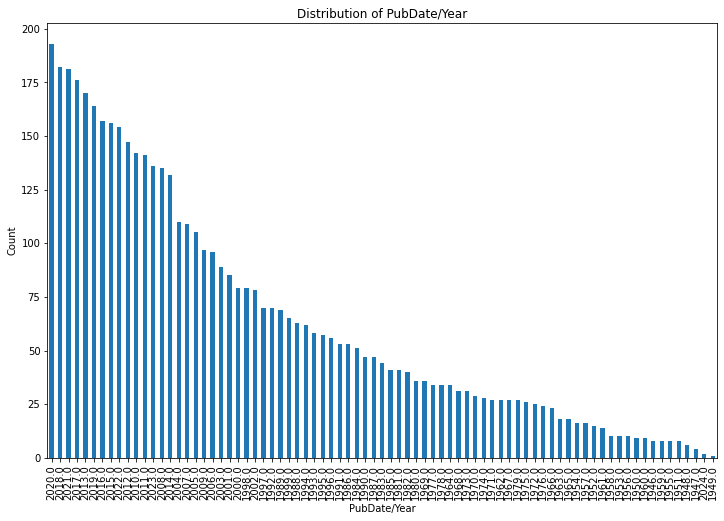

In [24]:
import matplotlib.pyplot as plt

# Increase the figure size
plt.figure(figsize=(12, 8))

# Assuming df is your DataFrame
# Plot the distribution of values in PubDate/Year
df['PubDate/Year'].value_counts().plot(kind='bar')

plt.xlabel('PubDate/Year')
plt.ylabel('Count')
plt.title('Distribution of PubDate/Year')

# Display the plot
plt.show()


In [25]:
df_cleaned = df.dropna(subset=['AbstractText'])

In [26]:
df_cleaned.shape

(3560, 6)

In [27]:
# Fill NaN values with an empty string
df_cleaned = df_cleaned.fillna('')
df_cleaned['AbstractText'] = df_cleaned['AbstractText'].str.replace('"', "\'")
df_cleaned['ArticleTitle'] = df_cleaned['ArticleTitle'].str.replace('"', "\'")

# Concatenate the desired columns with ^ separator
df_cleaned['text'] = df_cleaned[['Journal/Title', 'ArticleTitle', 'AbstractText']].apply(lambda x: '^\\n'.join(map(str, x)), axis=1)

# Create a new DataFrame with only the required columns
result_df = df_cleaned[['PMID', 'text']]
result_df.to_csv("./prodigy/input/all_{}_pubmed_with_abstracts.csv".format(len(result_df)))

### Prepare in JSONL format for Prodigy

In [28]:
# Set a seed for reproducibility
np.random.seed(42)

# Randomly sample 2000 rows
sampled_df = result_df.sample(n=2000)

# Split into two DataFrames
pilot_df = sampled_df.head(500)
postpilot_df = sampled_df.tail(1500)

# Convert the DataFrames to JSONL format
pilot_jsonl_data = pilot_df.to_dict(orient='records')
postpilot_jsonl_data = postpilot_df.to_dict(orient='records')

# Save the sampled data to JSONL files
with open('./prodigy/input/pilot_500_pubmed_abstracts.jsonl', 'w') as pilot_file:
    for line in pilot_jsonl_data:
        pilot_file.write(f'{{"pmid": "{line["PMID"]}", "text": "{line["text"]}"}}\n')

with open('./prodigy/input/postpilot_1500_pubmed_abstracts.jsonl', 'w') as postpilot_file:
    for line in postpilot_jsonl_data:
        postpilot_file.write(f'{{"pmid": "{line["PMID"]}", "text": "{line["text"]}"}}\n')


In [29]:
# Convert the DataFrame to JSONL format
jsonl_data = result_df.to_dict(orient='records')

# Save the JSONL data to a file
with open('./prodigy/pubmed_abstracts.jsonl', 'w') as jsonl_file:
    for line in jsonl_data:
        jsonl_file.write(f'{{"pmid": "{line["PMID"]}", "text": "{line["text"]}"}}\n')

In [30]:
result_df

,PMID,text
1,26201,Acta virologica^\nTransmissible virus dementia...
2,50412,Journal of neurology^\nIophendylate cisternogr...
3,61390,"Lancet (London, England)^\nCardiopulmonary res..."
4,63356,Child psychiatry and human development^\nNegot...
8,78395,"Lancet (London, England)^\nHaemophilus meningi..."
...,...,...
4994,37860852,European journal of psychotraumatology^\nTreat...
4995,37900065,Journal of medicine and life^\nA retrospective...
4996,37905374,Cognitive science^\nRepeat After Me? Both Chil...
4997,37951702,Neuroimaging clinics of North America^\nTreatm...


## Second Pilot

In [4]:
input_file_path = './prodigy/input/postpilot_1500_pubmed_abstracts.jsonl'
sampled_file_path = './prodigy/input/pilot_2_sampled_200.jsonl'
remaining_file_path = './prodigy/input/remaining_1300.jsonl'

# Read the JSONL file
with open(input_file_path, 'r') as file:
    lines = file.readlines()

# Randomly sample 200 lines
sampled_lines = random.sample(lines, 200)

# Save the sampled lines to one file
with open(sampled_file_path, 'w') as sampled_file:
    sampled_file.writelines(sampled_lines)

# Save the remaining lines to another file
remaining_lines = [line for line in lines if line not in sampled_lines]
with open(remaining_file_path, 'w') as remaining_file:
    remaining_file.writelines(remaining_lines)

## Set prodigy ids

In [1]:
import json

# Read the JSONL file
with open("./prodigy/annotated_output/pilot_500_pubmed_abstracts_shirin.jsonl", 'r') as file:
    lines = file.readlines()

# Process each line
for i, line in enumerate(lines):
    data = json.loads(line)

    # Replace values
    data['_session_id'] = 'pilot-500-shirin'
    data['_annotator_id'] = 'shirin'

    # Convert back to JSON string
    lines[i] = json.dumps(data) + '\n'

# Write the modified data back to the file
with open('./prodigy/annotated_output/pilot_500_pubmed_abstracts_shirin_correct_id.jsonl', 'w') as file:
    file.writelines(lines)